# Simulation of XYZ spin models using Floquet engineering in XY mode

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import qutip

import pulser
from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation
from pulser.devices import MockDevice, Chadoq2
from pulser.waveforms import BlackmanWaveform

In this notebook, we will reproduce some results of "Microwave-engineering of programmable XXZ Hamiltonians in arrays of Rydberg atoms", P. Scholl, et. al., https://arxiv.org/pdf/2107.14459.pdf.

### Floquet Engineering on two atoms

We start by considering the dynamics of two interacting atoms under $H_{XXZ}$. To demonstrate the dynamically tunable aspect of the microwave engineering, we change the Hamiltonian during the evolution of the system. More specifically, we start from $|\rightarrow \rightarrow \rangle_y $, let the atoms evolve under $H_{XX}$ and apply a microwave pulse sequence between $0.9\mu s$ and $1.2\mu s$ only.

Let us first define our $\pm X$ and  $\pm Y$ pulses. 

In [2]:
# Times are in ns
t_pulse = 26

X_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, 0)
Y_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, -np.pi/2)
mX_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, np.pi)
mY_pulse = Pulse.ConstantDetuning(BlackmanWaveform(t_pulse, np.pi/2.), 0, np.pi/2)

Let's also define a function to add the pulses during one cycle.

In [3]:
def Floquet_XXZ_cycles(n_cycles, tau_1, tau_2, t_pulse):
    t_half = t_pulse/2.
    tau_3 = tau_2 
    tc = 4*tau_2 + 2*tau_1
    for _ in range(n_cycles):
        seq.delay(tau_1-t_half, 'MW')
        seq.add(X_pulse, 'MW')
        seq.delay(tau_2-2*t_half, 'MW')
        seq.add(mY_pulse, 'MW')
        seq.delay(2*tau_3-2*t_half, 'MW')
        seq.add(Y_pulse, 'MW')
        seq.delay(tau_2-2*t_half, 'MW')
        seq.add(mX_pulse, 'MW')
        seq.delay(tau_1-t_half, 'MW')

We are ready to start building our sequence.

In [4]:
# We take two atoms distant by 10 ums.
coords = np.array([[0, 0], [10, 0]])
qubits = dict(enumerate(coords))
reg = Register(qubits)

seq = Sequence(reg, MockDevice)
seq.declare_channel('MW', 'mw_global')
seq.set_magnetic_field(0., 0., 1.)

tc = 300
seq.delay(3 * tc, 'MW')
Floquet_XXZ_cycles(4, tc/6., tc/6., t_pulse)
seq.delay(6 * tc, 'MW')  

# Here are our evaluation times
t_list= []
for p in range(13):
    t_list.append(tc/1000.*p)

Let's draw the sequence, to see that the microwave engineering only happens between $900 ns$ and $2100 ns$, which corresponds to $H_{XX} \to H_{XXX}$. During that period, the total y-magnetization $\langle \sigma^y_1 + \sigma^y_2 \rangle$ is expected to be frozen, as this quantity commutes with $H_{XXX}$.

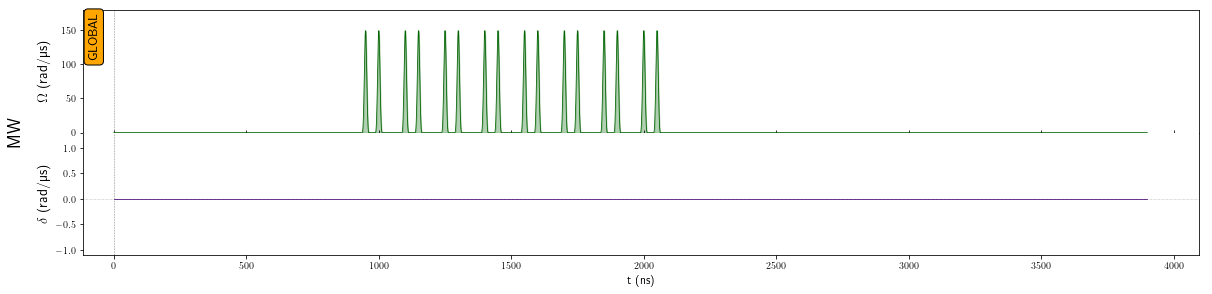

In [5]:
seq.draw()

In [6]:
sim = Simulation(seq, sampling_rate=1.0, config=None, evaluation_times=t_list)
psi_y = (qutip.basis(2, 0)+1j*qutip.basis(2, 1)).unit()
sim.initial_state = qutip.tensor(psi_y, psi_y)
res = sim.run()

In [7]:
sy = qutip.sigmay()
Id = qutip.qeye(2)
Sigma_y = (qutip.tensor(sy, Id)+qutip.tensor(Id, sy))/2.
Sigma_y_res = res.expect([Sigma_y])

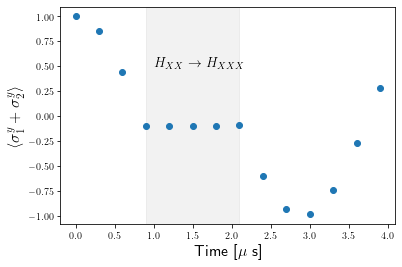

In [8]:
plt.figure()

# Showing the Hamiltonian engineering period.
line1 = 0.9
line2 = 2.1 
plt.axvspan(line1, line2, alpha=.1, color='grey')
plt.text(1., 0.5, r"$H_{XX} \to H_{XXX}$", fontsize=14)

plt.plot(sim.evaluation_times, Sigma_y_res[0], 'o')
plt.xlabel(r"Time [$\mu$ s]", fontsize=16)
plt.ylabel(fr'$ \langle \sigma_1^y + \sigma_2^y \rangle$', fontsize=16)
plt.show()

### Domain-wall dynamics

Now, we will look at the dynamics of the system under $H_{XX2Z}$ when starting in a Domain-Wall (DW) state $|\psi_0\rangle = |\uparrow \uparrow \uparrow \uparrow \uparrow \downarrow \downarrow \downarrow \downarrow \downarrow\rangle $, for two distinct geometries : open boundary conditions (OBC) and periodic boundary conditions (PBC). In the case of $H_{XX2Z}$, only 2 pulses per Floquet cycle are required, as the $X$ and $-X$ pulses cancel out.

In [9]:
def Floquet_XX2Z_cycles(n_cycles, t_pulse):
    t_half = t_pulse/2.
    tau_3 = tau_2 = tc/4.
    for _ in range(n_cycles):
        seq.delay(tau_2-t_half, 'MW')
        seq.add(mY_pulse, 'MW')
        seq.delay(2*tau_3-2*t_half, 'MW')
        seq.add(Y_pulse, 'MW')
        seq.delay(tau_2-t_half, 'MW')

In [10]:
N_at = 10
# Number of Floquet cycles 
N_cycles = 20 
# In the following, we will take 1000 projective measurements of the system at the final time.
N_samples = 1000 

Let's also create the initial state of the system using QuTiP.

In [11]:
# Creation of the initial DW state
initial_DW_state=[]
for m in range(N_at):
    if m<N_at//2:
        initial_DW_state.append(qutip.basis(2, 0))
    else:
        initial_DW_state.append(qutip.basis(2, 1))
    
initial_DW_state = qutip.tensor(initial_DW_state)

In [12]:
# Line geometry
reg = Register.rectangle(1, N_at, 10)

magnetizations_obc = np.zeros((N_at, N_cycles), dtype=float)
correl_obc = np.zeros(N_cycles, dtype=float)
for m in range(N_cycles):  # Runtime close to 2 min!
    seq = Sequence(reg, MockDevice)
    seq.declare_channel('MW', 'mw_global')
    seq.set_magnetic_field(0., 0., 1.)
    seq.add(X_pulse, 'MW')
    Floquet_XX2Z_cycles(m, t_pulse)
    seq.add(mX_pulse, 'MW')
    sim = Simulation(seq)
    sim.initial_state = initial_DW_state
    res = sim.run()
    samples = res.sample_final_state(N_samples)
    correl = 0.
    for key, value in samples.items():
        for j in range(N_at):
            correl -= (2*float(key[j])-1)*(2*float(key[(j+1)%N_at])-1)*value/N_samples 
            magnetizations_obc[j][m] += (2*float(key[j])-1)*value/N_samples
    correl_obc[m] = N_at/2+correl/2

In [13]:
# Circular geometry
coords = 10.*N_at/(2*np.pi)*np.array([(np.cos(theta*2*np.pi/N_at), np.sin(theta*2*np.pi/N_at)) for theta in range(N_at)])
reg = Register.from_coordinates(coords)

magnetizations_pbc = np.zeros((N_at, N_cycles), dtype=float)
correl_pbc = np.zeros(N_cycles, dtype=float)
for m in range(N_cycles):  # Runtime close to 2 min!
    seq = Sequence(reg, MockDevice)
    seq.declare_channel('MW', 'mw_global')
    seq.set_magnetic_field(0., 0., 1.)
    seq.add(X_pulse, 'MW')
    Floquet_XX2Z_cycles(m, t_pulse)
    seq.add(mX_pulse, 'MW')
    sim = Simulation(seq)
    sim.initial_state = initial_DW_state
    res = sim.run()
    samples = res.sample_final_state(N_samples)
    correl = 0.
    for key, value in samples.items():
        for j in range(N_at):
            correl -= (2*float(key[j])-1)*(2*float(key[(j+1)%N_at])-1)*value/N_samples 
            magnetizations_pbc[j][m] += (2*float(key[j])-1)*value/N_samples
    correl_pbc[m] = N_at/2+correl/2

Let's plot the evolution of the magnetization $\langle \sigma^z_j \rangle$ in time for all the sites $j$.

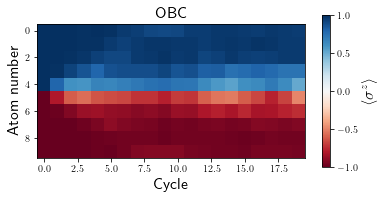

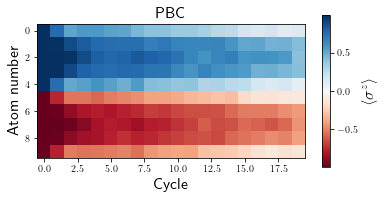

In [14]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(magnetizations_obc, cmap=plt.get_cmap('RdBu'))
plt.title('OBC',fontsize=16)
ax.set_xlabel('Cycle',fontsize=16)
ax.set_ylabel('Atom number',fontsize=16)
cbar = fig.colorbar(img, shrink=0.7)
cbar.set_label(r'$\langle \sigma^z \rangle$', fontsize=16)


fig, ax = plt.subplots(1,1)
img = ax.imshow(magnetizations_pbc, cmap=plt.get_cmap('RdBu'))
plt.title('PBC',fontsize=16)
ax.set_xlabel('Cycle',fontsize=16)
ax.set_ylabel('Atom number',fontsize=16)
cbar = fig.colorbar(img, shrink=0.7)
cbar.set_label(r'$\langle \sigma^z \rangle$', fontsize=16)

We see that the magnetization profiles look rather different for OBC and PBC. It seems that the initial DW melts in the case of PBC. In fact, the decrease of $|\langle \sigma^z_j \rangle|$ for all sites is due to a delocalization of the DW along the circle. This delocalization can be more apparent when looking at correlations. More specifically, we see on the plot below that the number of spin flips between consecutive atoms along the circle, $\langle N_{flip} \rangle=1/2\sum_j(1-\langle \sigma_j^z \sigma_{j+1}^z\rangle)$, remains quite low during the dynamics for both OBC (red) and PBC (blue), while it should tend to $N_{at}/2=5$ for randomly distributed spins. 

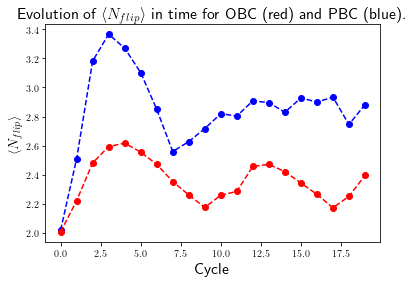

In [15]:
fig, ax = plt.subplots(1,1)
plt.title(r'Evolution of $\langle N_{flip} \rangle$ in time for OBC (red) and PBC (blue).', fontsize=16)
ax.set_xlabel('Cycle',fontsize=16)
ax.set_ylabel(r'$\langle N_{flip} \rangle$',fontsize=14)
ax.plot(correl_pbc,'--o',color='blue')
ax.plot(correl_obc,'--o',color='red')

To investigate even more this delocalization effect, let's consider a smaller region of only 3 spins prepared in $|\uparrow \rangle$. The delocalization timescale will then be shorter, and we will see it more clearly happening in the system

In [16]:
# Creation of the initial DW state with only 3 spins up.
initial_DW_state=[]
for m in range(N_at):
    if m < 3:
        initial_DW_state.append(qutip.basis(2, 0))
    else:
        initial_DW_state.append(qutip.basis(2, 1))
    
initial_DW_state = qutip.tensor(initial_DW_state)

In [17]:
N_cycles=26 # Runtime close to 4 min !

magnetizations_pbc = np.zeros((N_at, N_cycles), dtype=float)
samples_evol = []
for m in range(N_cycles):
    seq = Sequence(reg, MockDevice)
    seq.set_magnetic_field(0., 0., 1.)
    seq.declare_channel('MW', 'mw_global')
    seq.set_magnetic_field(0., 0., 1.)
    seq.add(X_pulse, 'MW')
    Floquet_XX2Z_cycles(m, t_pulse)
    seq.add(mX_pulse, 'MW')
    sim = Simulation(seq)
    sim.initial_state = initial_DW_state
    res = sim.run()
    samples = res.sample_final_state(N_samples)
    samples_evol.append(samples)
    correl = 0.
    for key, value in samples.items():
        for j in range(N_at):
            magnetizations_pbc[j][m] += (2*float(key[j])-1)*value/N_samples

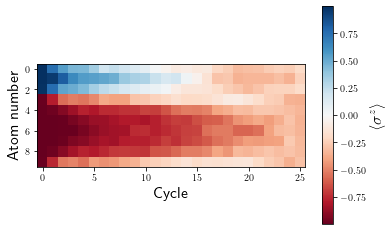

In [18]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(magnetizations_pbc, cmap=plt.get_cmap('RdBu'))
ax.set_xlabel('Cycle', fontsize=16)
ax.set_ylabel('Atom number', fontsize=16)
cbar = fig.colorbar(img)
cbar.set_label(r'$\langle \sigma^z \rangle$', fontsize=16)

We see above that the magnetization profile tends to average. But if we look at the histogram of sampled states in time, we will remark that domain-wall configurations are dominant (in red in the histograms below). As time increases, the delocalization mechanism populates more and more domain-wall states distinct from the initial state.

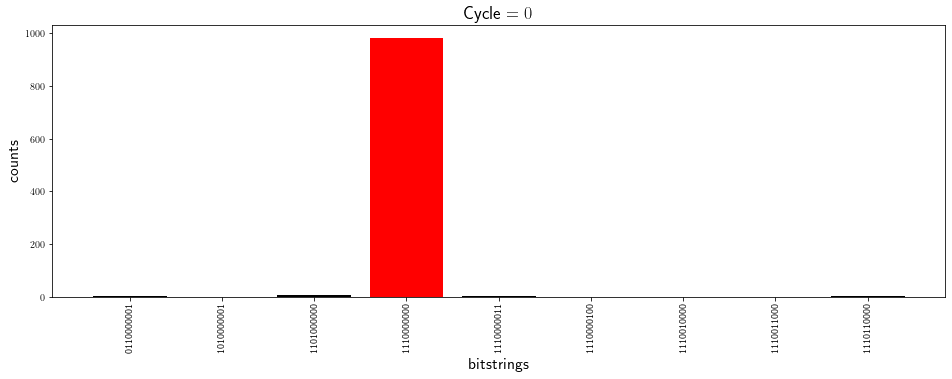

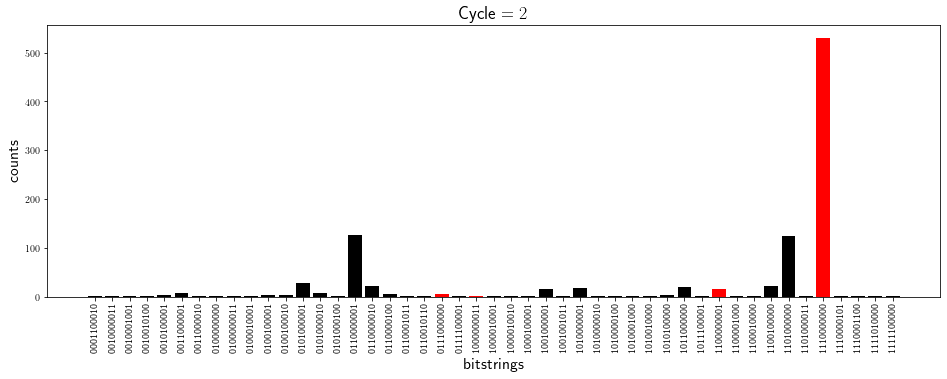

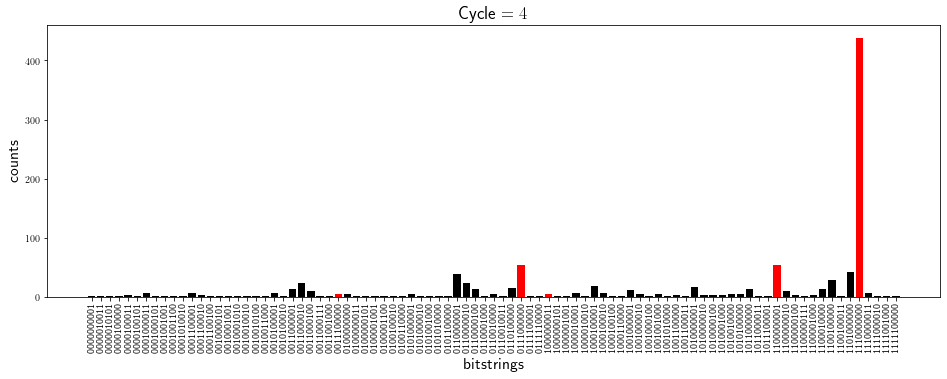

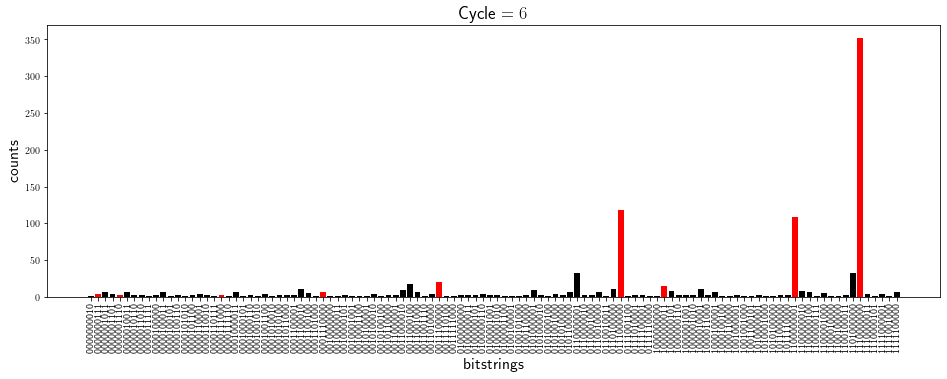

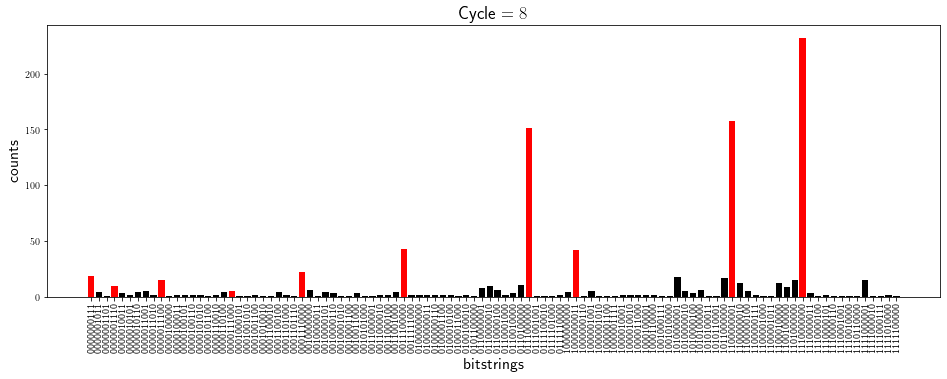

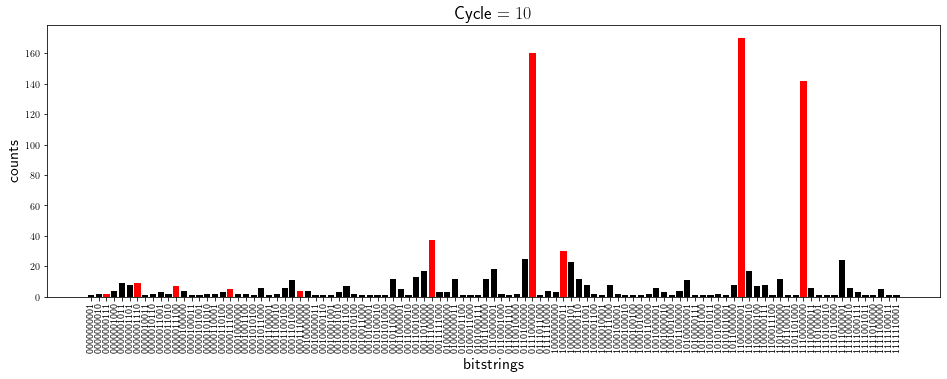

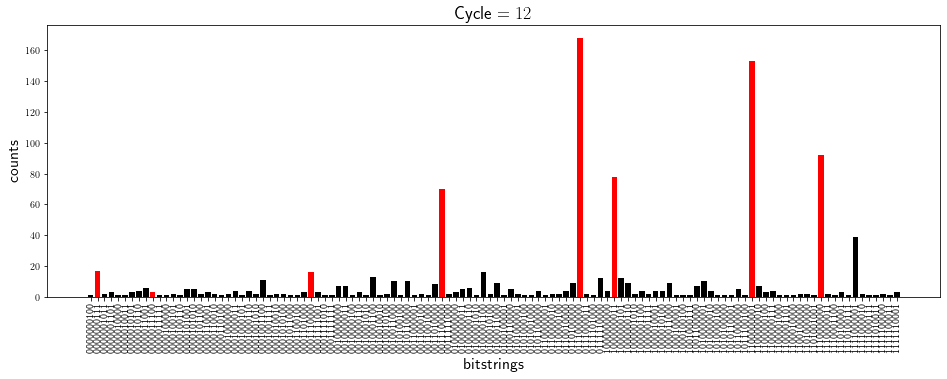

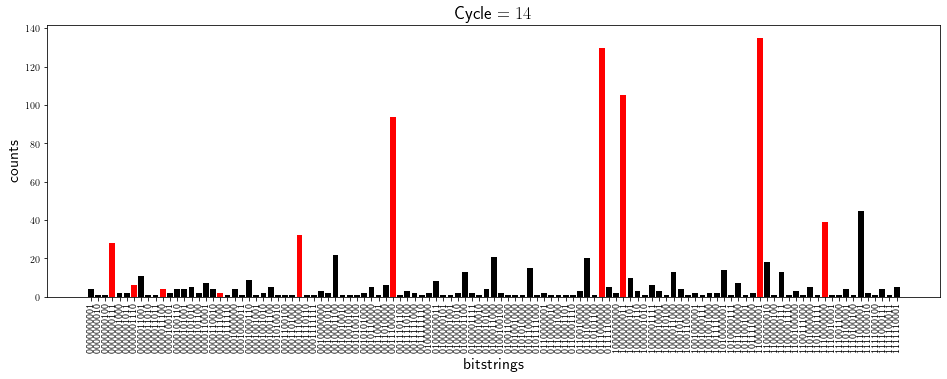

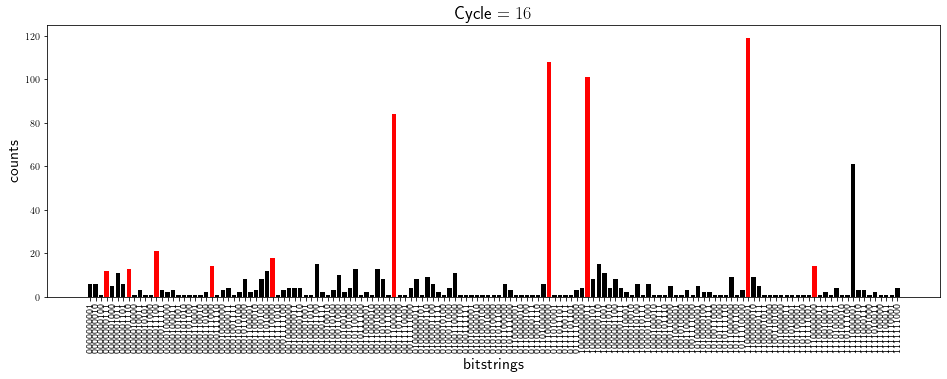

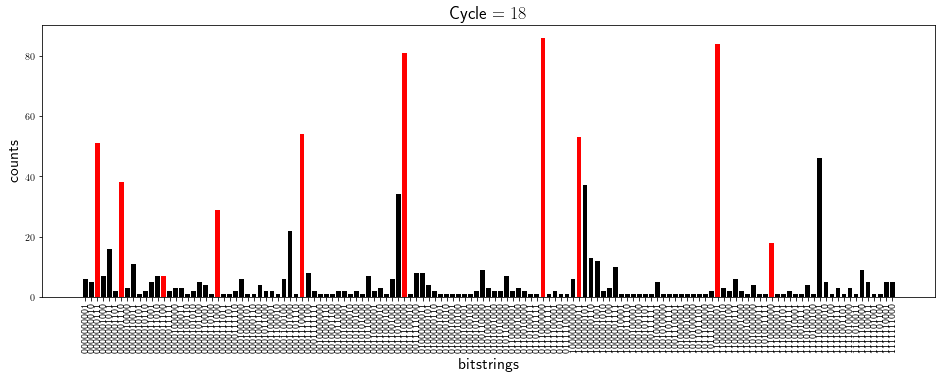

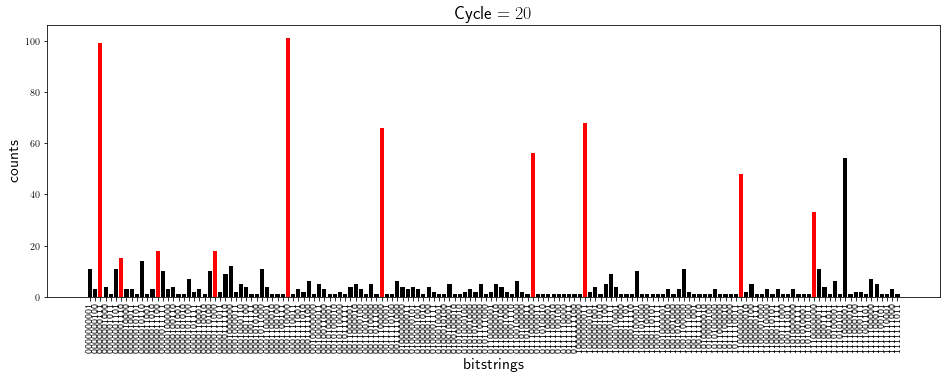

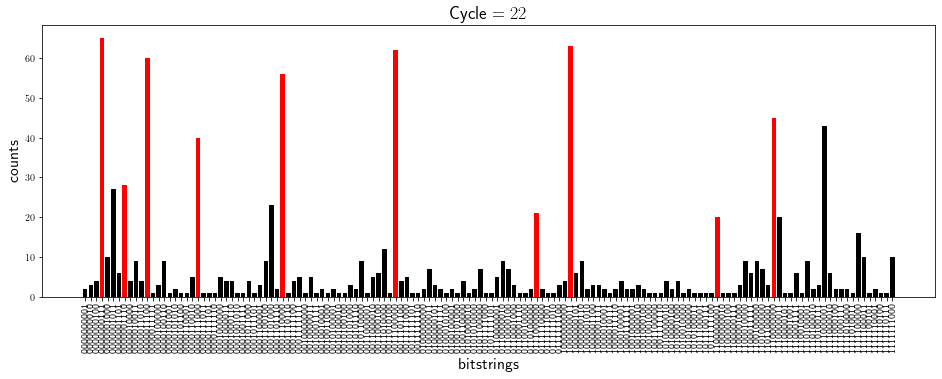

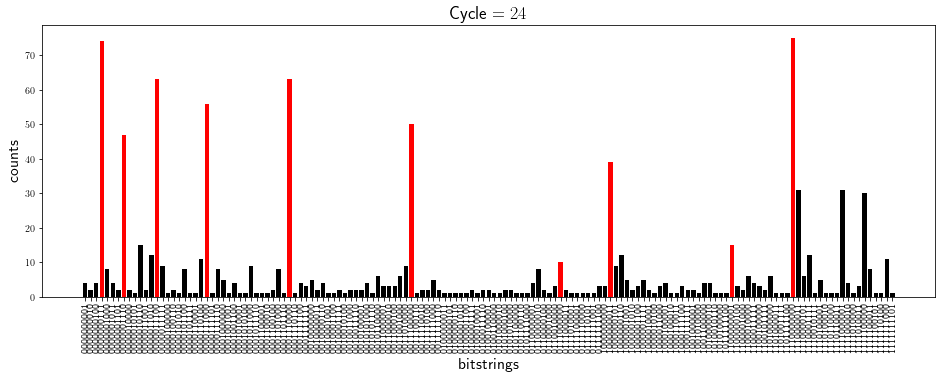

In [19]:
dw_preserved =['1110000000', '0111000000', '0011100000', '0001110000', 
                 '0000111000', '0000011100', '0000001110', '0000000111', '1000000011', '1100000001']

for n_cycle in [2*k for k in range(int(N_cycles/2))]: # Runtime close to 2 min !
    color_dict = {key: 'red' if key in dw_preserved else 'black' for key in samples_evol[n_cycle]}
    plt.figure(figsize=(16, 5))
    plt.title(r'Cycle $= {}$'.format(n_cycle), fontsize=18)
    plt.bar(samples_evol[n_cycle].keys(), samples_evol[n_cycle].values(), color=color_dict.values())
    plt.xlabel("bitstrings", fontsize=16)
    plt.ylabel("counts", fontsize=16)
    plt.xticks(rotation=90)
    plt.show()